## Linear Regression

Up to this point we have seen how you can get, clean, describe, and visualize data. Once you have a good understanding of your data and have cleaned it up, the next step is typically modeling. 

In this course, modeling will mean using a machine learning technique to learn - from data - the relationship between a set of features and what we hope to predict. Let's bring in some data to make this idea more concrete. 

In [1]:
from sklearn.datasets import load_boston
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer
%matplotlib inline

In [2]:
np.random.seed(42)

In [3]:
boston_data = load_boston()
boston_df = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [4]:
target = boston_data.target

Here is some description of our data:

* CRIM - per capita crime rate by town
* ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS - proportion of non-retail business acres per town.
* CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
* NOX - nitric oxides concentration (parts per 10 million)
* RM - average number of rooms per dwelling
* AGE - proportion of owner-occupied units built prior to 1940
* DIS - weighted distances to five Boston employment centres
* RAD - index of accessibility to radial highways
* TAX - full-value property-tax rate per 10,000 dollars
* PTRATIO - pupil-teacher ratio by town
* B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* LSTAT - percent lower status of the population
* TARGET - Median value of owner-occupied homes in $1000's

The goal of this dataset if to use the features (everything except the target) to predict the target (median home value). How might we do this? For our first pass, let's simplify the problem. Let's say we just want to use LSAT to predict TARGET. 

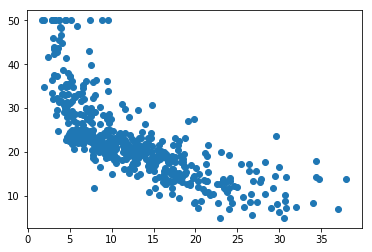

In [5]:
plt.scatter(boston_df['LSTAT'], target)

### Cost / Evaluation Function

How can we tackle this problem? A good place to start one's thinking is: say we develop many models to predict our target, how would we pick the best one? Once we determine this, our goal is then to minimize/maximize that value. 

It is extremely useful if you can reduce your problem to a single evaluation metric because then it makes it very easy to iterate on model development. In industry, though, this can be tricky. Sometimes it isn't extremely clear what you want your model to maximize/minimize. We will discuss this challenge more later in the class, but for now we will stick with pretty standard evaluation functions used today.

So for this problem, I would propose the following evaluation metric: mean squared error (MSE). To understand MSE, let's define some terminology:

* $\hat{y_{i}}$ - this is our predicted value for the ith data point
* $y_{i}$ - this is actual value for the ith data point
* $n$ - the number of data points

Thus, MSE is:

$\frac{1}{n} \sum_{i}{(y_{i} - \hat{y_{i}})^2}$

In English, for each point we subtract our predicted value from the actual. Then, since we don't care about the direction of the error, we square the difference. Lastly, we take the mean of all these values. Basically, we are saying that we want the average distance between our predictions and our actuals to be small. 

You might be wondering, why we squared the value instead of taking the absolute value. It turns out that for some of the following math, squaring the value works out nicely. Also, it is the MLE estimate. This does have the effect, though, of weighting large errors more in our average since we are squaring all the differences.

### Our model

Now that we have our cost function, how do we find a way to minimze it? In this lecture we will be reviewing the Linear Regression model. The model is as follows:

$\hat{y_{i}}$ = $\beta_{0} + \sum_{j}{B_{j}x_{j,i}}$

Where $j$ is the number of predictors we have and the $\beta$ values are our coefficients with $\beta_{0}$ being the intercept. Basically, our model is a linear combination of our predictors with an intercept.

Now that we have a model and a cost function, our challenge becomes finding the $\beta$ values for our model that minimize MSE for our data. For linear regression, there is actually a closed form solution called the [normal equation](http://mathworld.wolfram.com/NormalEquation.html). In this lecture, though, we are going to use a different technique that is more common in machine learning - gradient descent.

### Gradient Descent

Gradient descent is a technique we borrow from optimization. It is a very simple, yet powerful algorithm that can be used to find the minimum of a function.

1. Pick a random starting value
2. Take steps proportional to the negative of the gradient at the current point
3. Repeat until you converge

This technique will find the global minimum if a function is convex, if not, we can only prove that it will find a local minimum. Let's take a look at an [example](https://medium.com/onfido-tech/machine-learning-101-be2e0a86c96a). 

The first question we need to answer is: is our cost function convex? Let's take a look:

Min MSE: 166790.9803
Coeff: 1


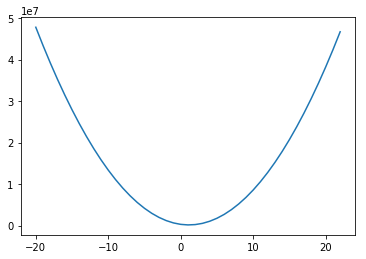

In [6]:
import numpy as np

mses = []
lstat_coef = range(-20, 23)
for coef in lstat_coef:
    pred_values = np.array([coef * lstat for lstat in boston_df.LSTAT.values])
    mses.append(np.sum((target - pred_values)**2))
    
plt.plot(lstat_coef, mses)
print("Min MSE: {}".format(np.min(mses)))
print("Coeff: {}".format(lstat_coef[np.argmin(mses)]))

What we have done above is taken a range of coefficient values for LSTAT and for each one calculated the MSE on our data. If we then plot these we get the above curve - looks pretty convex! And in fact, it turns out that our MSE function with our linear regression model will always be convex! That means we can use gradient descent to find the optimal coefficients for our model!

One reason that gradient descent is more common than the normal equation for machine learning is that it scales much better as we increase the number of features. It is also a general optimization technique that pops up all over machine learning, so understanding how it works is extremely valuable.

### Gradients

If you look at our pseudocode for gradient descent again, you will see that really all we need to do is calculate gradients. So - what are gradients? You can probably guess from the animations we saw, but they are just the partial derivatives with respect to the coefficients. For each coefficient we have, we will need to calculate the derivatie of our MSE with respect to that coefficient. Let's get started! 

Remeber our cost function: $\frac{1}{n} \sum_{i}{(y_{i} - \hat{y_{i}})^2}$

Now, let's expand it out for our simple example with an intercept and a single variable, LSTAT:

$\frac{1}{n} \sum_{i}{(y_{i} - (\beta_{0} + \beta_{1} * LSTAT_{i}))^2}$

Now, for the derivative of this with respect to $\beta_{0}$, we get:

$\frac{2}{n} \sum_{i}{(y_{i} - (\beta_{0} + \beta_{1} * LSTAT_{i}))}$ * -1

And for $\beta{1}$:

$\frac{2}{n} \sum_{i}{(y_{i} - (\beta_{0} + \beta_{1} * LSTAT_{i}) * -LSTAT_{i})}$

Now, let's see this gradient descent algorithm in code:

In [47]:
beta_0 = 0
beta_1 = 0
learning_rate = 0.001
lstat_values = boston_df.LSTAT.values
n = len (lstat_values)
all_mse = []
for _ in range(10000):
    predicted = beta_0 + beta_1 * lstat_values
    residuals = target - predicted
    all_mse.append(np.sum(residuals**2))
    beta_0 = beta_0 - learning_rate * ((2/n) * np.sum(residuals) * -1)
    beta_1 = beta_1 - learning_rate * ((2/n) * residuals.dot(lstat_values) * -1)

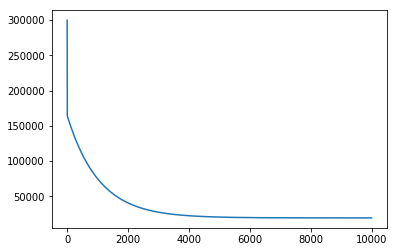

In [48]:
plt.plot(range(len(all_mse)), all_mse)

In [49]:
beta_0

34.27230357706076

In [50]:
beta_1

-0.9331466362919295

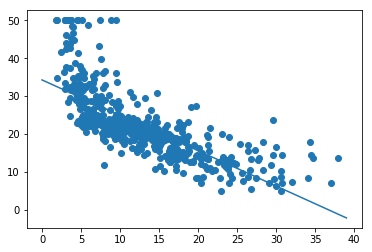

In [51]:
plt.scatter(boston_df['LSTAT'], target)
x = range(0, 40)
plt.plot(x, [beta_0 + beta_1 * l for l in x])

Nice! It looks like it worked! But let's discuss a few things:

### Learning rate

As you noticed from the code, the learning rate is a hyper-parameter used to determine how far we step away from the direction of the gradient. How do you know what value to pick? Typically, many values can be tried and here are a few that I believe are suggested by Andrew Ng: .001, .003, .01, .03, .1, .3, 1, 3

Choosing a value that is too small, leads to slower convergence. Choosing a value too large can result in over-shooting the minimum and diverging. 

There are also other gradient descent optimizers that are more sophisticated and adapt the learning rate over time for you. This is also something you can do on your own where you slowly decay the learning rate over time. You can read more about different optimizers [here](http://ruder.io/optimizing-gradient-descent/index.html#adam).

### When to stop iterating?

In my code, I simply choose to run our loop 10,000 times. Why 10,000. No real reason other than I was pretty sure it was long enough to converge. That is typically not the best practice. A few better ideas are:

1. Monitor your cost after each loop and when it decreases by less than some tolerance - say 0.001 - stop.
2. Use a validation set and track the loss - for example, MSE - on that. When it stops decreasing, stop.

### Matrix optimizations

My code above is more for teaching and is far from optimal. It is much more efficient to update all of the weights in a single matrix operation using numpy.

### Normalizing data

When working with gradient descent you want all of your data normalized as discussed in the previous lecture. Subtract from the mean and divide by the standard deviation for all your training features. This typically makes the training faster and reduces the chances of getting stuck in local optimum if your cost function is not convex.

### Other types of gradient descent

The gradient descent we have show here is a vanilla form, which means each coefficient update uses all of the data to calculate the gradients. There is also **stochastic gradient descent** which only uses 1 row of data to update the coefficients in each loop. This is much more scalable as you only have to look at one data row at a time, but is also much more random as you are trying to navigate using a gradient calculated on only a single data point. This introduces a new term as well: **epoch** which is the number of times you want to loop over your data.

Another type of gradient descent is **mini-batch gradient descent**. This form is a compromise between the two where you choose a batch size of say 32 (or even better a batch schedule which starts with small batches and increases over the number of epochs) and each iteration of your gradient descent gets to use 32 random rows of data to calculate the gradient with. This offers some scalabilty and some randomness. This randomness it turns out is actually useful for cost functions which are not convex (deep learning) as it can help the model escape local minimum. This is the most common method for non-convex cost functions.

## Assumptions of our model

Whenever you are dealing with a model it is good to be aware of the assumptions it is making. I was going to write up a section on this here, but Duke already did an excellent job: http://people.duke.edu/~rnau/testing.htm. You can also read more on this in "Data Science From Scratch" chapter 15.

## Using SKLearn

Now that we understand a bit of the theory and implementation, let's turn to a software library to actually run linear regression on our data. It is very useful for learning to write models from scratch, but it practice you are usually much better off using a tested and widely used library.

In [26]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

Remeber to scale your data - very important!

In [53]:
scaler = StandardScaler()
scaler.fit(boston_df)
scaled_df = scaler.transform(boston_df)
scaled_df[0:5]

array([[-0.41978194,  0.28482986, -1.2879095 , -0.27259857, -0.14421743,
         0.41367189, -0.12001342,  0.1402136 , -0.98284286, -0.66660821,
        -1.45900038,  0.44105193, -1.0755623 ],
       [-0.41733926, -0.48772236, -0.59338101, -0.27259857, -0.74026221,
         0.19427445,  0.36716642,  0.55715988, -0.8678825 , -0.98732948,
        -0.30309415,  0.44105193, -0.49243937],
       [-0.41734159, -0.48772236, -0.59338101, -0.27259857, -0.74026221,
         1.28271368, -0.26581176,  0.55715988, -0.8678825 , -0.98732948,
        -0.30309415,  0.39642699, -1.2087274 ],
       [-0.41675042, -0.48772236, -1.30687771, -0.27259857, -0.83528384,
         1.01630251, -0.80988851,  1.07773662, -0.75292215, -1.10611514,
         0.1130321 ,  0.41616284, -1.36151682],
       [-0.41248185, -0.48772236, -1.30687771, -0.27259857, -0.83528384,
         1.22857665, -0.51117971,  1.07773662, -0.75292215, -1.10611514,
         0.1130321 ,  0.44105193, -1.02650148]])

SKLearn has a very nice API. It provides many models and all of them have a fit and predict function. You call fit on the X and y data to train the model and the predict on new features to get a predicted value. SKLearn also provides a lot of metrics you can use for evaluation such as MSE. Here I output root MSE (RMSE) because that gets us back into the original scale of our target, which I find easier to understand.

With our SGDRegressor tol tells the model when to stop iterating and eta0 is our initial learning rate.

In [28]:
linear_regression_model = SGDRegressor(tol=.0001, eta0=.01)
linear_regression_model.fit(scaled_df, target)
predictions = linear_regression_model.predict(scaled_df)
mse = mean_squared_error(target, predictions)
print("RMSE: {}".format(np.sqrt(mse)))

RMSE: 4.685734304481881


### Polynomial Variables

If you remember our plot of LSTAT against our target, there looked to be a polynomial relationship. Linear regression fits linear relationships, but if you add polynomial features, such as LSTAT^2 you can fit more complex relationships. SKLearn makes this easy:

In [29]:
from sklearn.preprocessing import PolynomialFeatures

In [30]:
poly = PolynomialFeatures(2, include_bias=False)
poly_df = poly.fit_transform(boston_df)
scaled_poly_df = scaler.fit_transform(poly_df)
print(scaled_poly_df.shape)

(506, 104)


In [31]:
linear_regression_model.fit(scaled_poly_df, target)
predictions = linear_regression_model.predict(scaled_poly_df)
mse = mean_squared_error(target, predictions)
print("RMSE: {}".format(np.sqrt(mse)))

RMSE: 3.2434773093121825


The polynomial features command generated a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree (in our example 2). We then scaled these data and feed them to our model. And we got a better RMSE. Excellent! Note, though, that these results are not very valid because they are applied to our testing data. Later in this lecture we will look at how to better evaluate the generalizability of our models.

### Categorical variables

Linear regression is one of the models that you need to be careful with when you have categorical data. If you have a features with values 1, 2, and 3 that actually mean Male, Female, No Response. You don't want to give it to the model this way even though they are numbers. If you did, the model would assign that feature a coefficient - perhaps 0.1. That would mean that being a female boosts the prediction by .1 and No response by .2. But maybe female should boost the score by 1.2 and No response by only .001. To account for this, you should convert these values to dummy variables as described in the previous lecture so that each value can have its own weight. Unless you are confident there is a constant relationship in the order of your numeric values.

## Interpreting your model

Linear regression is a great statistical model that has been around for a long time. There are many statistical techiques that one can use to evaluate and interpret it. We will not cover them all and in fact will mostly focus on very simple methods that are perhaps more common in machine learning than statistics. To get a better grasp of the statistical techniques, please read chapter 3 of [Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/) and take a look at the [statsmodels](http://www.statsmodels.org/stable/index.html) package.

First, let's take a look at the coefficients our model has learned:

In [32]:
linear_regression_model.fit(scaled_df, target)
sorted(list(zip(boston_df.columns, linear_regression_model.coef_)), key=lambda x: abs(x[1]))

[('AGE', -0.029870864499927312),
 ('INDUS', -0.11680882000151262),
 ('CHAS', 0.7251651849373875),
 ('B', 0.860833232751562),
 ('CRIM', -0.8776771165647126),
 ('ZN', 0.9642122737571711),
 ('TAX', -1.358984598705047),
 ('NOX', -1.9123308732835265),
 ('RAD', 1.9895291420964234),
 ('PTRATIO', -2.035834639863396),
 ('RM', 2.7500312260845527),
 ('DIS', -3.0276404995025414),
 ('LSTAT', -3.7137758103897065)]

What are these coefficients? They represent the average change in the housing price for one unit of change in the feature while holding other features in the model constant. For example, holding all else constant, a unit increase in LSTAT decreases our target (housing price) by 3.469 and a unit increase in RM increases our target by 3.062.

This is really nice! We can perhaps say that if you want to increase the house values, that increasing RM and decreasing LSTAT might be a place to start. I say might because linear regression is looking at correlations. In our data, this definitely appears to be the case, but that by-itself does not mean that these features have a causal relationship. It could be a good place to look for a causaul relationship, though, and does represent relationships that were seen in the data.

## Confidence Intervals

Often in machine learning it is very useful to have a confidence interval around your estimates. There are different ways to do this, but one fairly general method is using a **bootstrap.**

A bootstrap is a random sample with replacement of our data and this sample is of the same size of the original data. This is a way of generating multiple views of the same data. Let's create 1000 bootstraps of our data.

In [33]:
from sklearn.utils import resample
n_bootstraps = 1000
bootstrap_X = []
bootstrap_y = []
for _ in range(n_bootstraps):
    sample_X, sample_y = resample(scaled_df, target)
    bootstrap_X.append(sample_X)
    bootstrap_y.append(sample_y)

Then on each of these datasets, we can fit our model and get our coefficents:

In [34]:
linear_regression_model = SGDRegressor(tol=.0001, eta0=.01)
coeffs = []
for i, data in enumerate(bootstrap_X):
    linear_regression_model.fit(data, bootstrap_y[i])
    coeffs.append(linear_regression_model.coef_)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 13 Text xticklabel objects>)

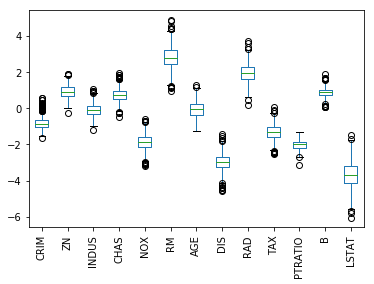

In [35]:
coef_df = pd.DataFrame(coeffs, columns=boston_df.columns)
coef_df.plot(kind='box')
plt.xticks(rotation=90)

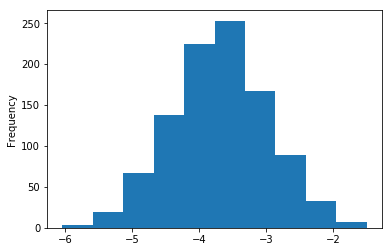

In [36]:
coef_df['LSTAT'].plot(kind='hist')

In [22]:
coef_df['LSTAT'].describe()

count    1000.000000
mean       -3.599465
std         0.687444
min        -5.825069
25%        -4.058086
50%        -3.592409
75%        -3.120958
max        -1.575822
Name: LSTAT, dtype: float64

This is pretty nice! Now we can say with strong confidence that the actual coefficient on LSTAT is negative and almost certaintly between -1.2 and -5.5. And probably with +- 2 std. You can see from the box plots as well that LSTAT and RM have a slightly larger range than some of the other variables.

## Train / Test Split and Cross Validation

Up to this point, we have been training on all the data that we have. This might make sense because we want to maximize the utility of our data by using as much as possible for training. On the other hand, though, it makes it hard to evaluate how well our model is doing. The reason for this is because if we just calculate our MSE score using data that the model was trained on, we might find that we introduced to data it was not trained on, it performs quite poorly. 

This idea is called **overfitting**. Basically, when a model performs much better on the data it was trained on as opposed to new data, it has overfit to something unique to the training data that doesn't generalize.

The other side of this is called **bias.** A model has high bias when it really just doesn't do a good job fitting to the data. In this case the MSE will be high for both the training data and data not seen during training.

In machine learning, there is always a trade-off between bias and variance. As your models become more complex, there is a stronger risk of overfitting to your training data.

Now that we know there are issues with only looking at MSE on our training data, what can we do to better judge generalizability? As well as diagnose overfitting and bias? Typically, we split our data into two sets: a training set and a testing set.

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(scaled_df, target, test_size=0.33, random_state=42)

Now that we have two seperate sets of data, we can train on our training data and calculate metrics for both our training and testing data:

In [24]:
linear_regression_model = SGDRegressor(tol=.0001, eta0=.01)
linear_regression_model.fit(X_train, y_train)
train_predictions = linear_regression_model.predict(X_train)
test_predictions = linear_regression_model.predict(X_test)

train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))

Train MSE: 23.33856804462054
Test MSE: 21.820947809040835


Excellent! Now we have RMSE on both our training and testing data. And both our pretty close, which suggests we don't have an overfitting problem. Are they both low, though? Which would suggest a high bias.

One way to look into this is by plotting learning curve. A learning curve plots our error function (MSE) with various amounts of data used for training. Here is our plot:

In [25]:
## source: http://scikit-learn.org/0.15/auto_examples/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(mean_squared_error))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/Users/tfolkman/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

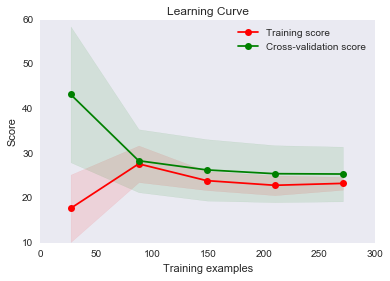

In [26]:
plot_learning_curve(linear_regression_model, "Learning Curve", X_train, y_train, cv=5)

You can see that with less than 50 training examples the training MSE is quite good and the cross-validation is quite bad (we have not talked about cross-validation yet, so think of that as testing for now). If we only had that much data then, it would look like a high variance problem.

As we increase our data, we begin to improve both of our scores and they become very close, which suggests we don't have a high variance problem. Typically, with high variance this graph would have the two lines fairly far apart and looking like if we continued to add more data, they might converge. 

This graph looks more like we have a high bias problem since our two curves are very close and flattening out. It is hard to say for sure, though, because we may have just reached the best MSE possible. In that case, this wouldn't be a high bias problem. It would only be a problem if our curves flattened out with an MSE higher than optimal. In real-life, you don't know what the optimal MSE is, so you have to theorize a bit as to whether you think decreasing bias would improve your score - or just try it!

### Fix high bias / high variance problems

So, now that you have diagnosed your bias or variance problem, how do you fix them?

For **high variance**:

* Get more training data
* Try a smaller set of features
* Try a less complex model
* Add regularization

For **high bias**:

* Try adding features
* Try a more complex model


### Cross validation and tuning hyper-parameters

Earlier we mentioned this phrase: cross validation. Let's talk about that now. So far, we have learned that it is a good idea to split your data into training and testing sets to better understand how well the model is actually doing. That is great, but imagine we want to test multiple different models or test different parameters to our model - for example, a different learning rate or tolerance. How would we decide which model or which parameter is best? Would we train everything on the training data and test everything on our testing data? Hopefully, you see that this doesn't make sense because then we would esentially be in the same place we were before without a way to test how well we do with never before seen data. So - we want to keep our testing set untainted in the sense that in a perfect world we would only run our tests on it after we have done all of our experimentation and think we have found the very best model.

It sounds like we need a third set of data - a validation set. Basically, what we can do is break down our training data into two sets: a training set and a validation set. All models will be trained on the training set and then tested on our validation set. We then take the model that does the best on validation and see how well it does on testing. Our testing results represent how well we think our model would do with unseen data - and then we are done.

Note: the assumption here is that our testing and validation sets our a representative sample of our population. For example, if the average home price in your validation set is 1 million, but in the population it is 300 thousand, you have a bad sample. Often, we randomly sample our available data into our three sets, but it is always good to confirm that these sets are good representations. Otherwise, you will find that your model that worked well in validation and testing performs poorly in production.

In practice, instead of creating a single validation set we often use k-fold cross-validation. What this does is we choose a value of k, say 3. We then take our training data and split it into 3 folds. We randomly select 2 folds to train on and then use the remaining for testing. We then repeat this 2 more times, for a total of 3 times such that that all observations are used for both training and validation, and each observation is used for validation exactly once. We would then average all the three scores (in our case MSE) to get a score for a particular model. We can then repeat this process for multiple models to find the best one.

Here is a video that describes this process more visually: https://www.youtube.com/watch?v=TIgfjmp-4BA

This process is very easy with sklearn:

In [27]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {"eta0": [ .001, .003, .01, .03, .1, .3, 1, 3]}

linear_regression_model = SGDRegressor(tol=.0001)

n_iter_search = 8
random_search = RandomizedSearchCV(linear_regression_model, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, scoring='neg_mean_squared_error')
random_search.fit(X_train, y_train)

print("Best Parameters: {}".format(random_search.best_params_))
print("Best Negative MSE: {}".format(random_search.best_score_))

Best Parameters: {'eta0': 0.01}
Best Negative MSE: -25.322156767075665


Here we actually usd Randomized search which typically is better than searching over all possible values. Often, you want to try many different parameters for many different knobs and grid searching over everything is not efficient. Usually, you want to use a randomized search as we did above. Though, since we only had a small number of values we forced it to be a grid-search by setting n_iter_search to the number of values we wanted to try.

We also set cv=3 to have 3 folds and used negative MSE because the CV functions in sklearn try to maximize a value.

You can learn more about random search and grid search here: http://scikit-learn.org/stable/modules/grid_search.html

Also, sklearn has many other CV functions that are useful especially if you want to test different models with the same folds. Here is some documentation: http://scikit-learn.org/stable/modules/cross_validation.html

### Regularization

As a means to account for high variance models, I mentioned regularization. You can think of regularization as a method used to penalize a model from learning complex relationships. For linear regression, that takes the form of three popular methods. All of these methods are centered around the idea of limiting how large the coefficients on our features can be. The idea being that if we overestimate the impact of a predictor (a large coefficient) it is likely that we are overfitting. Note: we can still have large coefficents. Regularization just says that the decrease in MSE has to justify the increase in coefficient magnitudes.

* L1 Regulariztion (Lasso): You add the sum of the absolute values of the coefficients to the cost function. This method can force coefficients to zero, which can then be a means of feature selection
* L2 Regularization (Ridge): You add the sum of the squared values of the coefficients to the cost function. 
* Elastic-net: You add both and choose how to weight them with 

Each of these methods takes a weighting factor that tells you how much you should weight the regularization term in the cost function. In sklearn, it is called alpha. An alpha of zero would add no penalty, while a high alpha would penalize the model a lot for having large coefficients. You can use cross-validation to discover a good value for alpha.

Sklearn makes this easy:

In [28]:
from sklearn.linear_model import ElasticNetCV

# l1 ratio of zero is l2 and visa-versa 
# alphas are how much to weight regularization
clf = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=[.1, 1, 10])
clf.fit(X_train, y_train)
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)
print("Train MSE: {}".format(mean_squared_error(y_train, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test, test_predictions)))

Train MSE: 23.500345265727802
Test MSE: 21.60819303537859
